<a href="https://colab.research.google.com/github/hailK11/WeatherPrediction_Keras/blob/master/Ml_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Weather Prediction with GRU in TensorFlow**

**Data Used** : 10 years weather data of city Basel, Switzerland

# Import necessary libraries

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# Load dataset

**Dataset details** 

*   Temperature : 2m above ground level, °C
*   Relative Humidity : 2m above ground, %
*   Mean Sea Level Pressure : MSL, hPa
*   Total Precipitation : sfc, mm
*   Snowfall Amount Raw : sfc, cm
*   Total cloud over : sfc, %
*   Sunshine Duration : sfc, min
*   Shortwave Radiation : sfc, W/m2
*   Wind Speed : 10m above ground,kmph
*   Wind Direction : 10m above ground, °
*   Wind Gust : sfc, kmph

In [0]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset (3).csv


In [0]:
import io

df = pd.read_csv(io.StringIO(uploaded['dataset.csv'].decode('utf-8')))

df.head(10)

,Year,Month,Day,Hour,Minute,Temperature,Humidity,Pressure,Precipitation,Snowfall,Total Cloud Cover,Sunshine Dur,Shortwave Radiation,Wind Speed,Wind Direction,Wind Gust
0,2008,10,1,0,0,12.92,70,1011.5,0.0,0.0,100.0,0.00,0.00,26.53,251.81,59.04
1,2008,10,1,1,0,12.52,74,1011.4,0.0,0.0,100.0,0.00,0.00,24.98,254.96,56.88
2,2008,10,1,2,0,12.52,75,1011.6,0.0,0.0,100.0,0.00,0.00,24.14,252.65,54.36
3,2008,10,1,3,0,12.32,78,1011.1,0.0,0.0,100.0,0.00,0.00,22.01,254.83,51.12
4,2008,10,1,4,0,12.41,77,1010.5,0.0,0.0,100.0,0.00,0.00,20.73,249.68,54.00
5,2008,10,1,5,0,12.11,70,1011.1,0.0,0.0,100.0,0.00,0.00,24.48,250.23,58.32
6,2008,10,1,6,0,12.11,70,1011.6,0.0,0.0,100.0,0.00,0.00,26.42,250.08,60.48
7,2008,10,1,7,0,12.13,68,1011.4,0.0,0.0,2.0,58.72,12.46,26.94,247.20,60.84
8,2008,10,1,8,0,13.24,63,1011.0,0.0,0.0,100.0,0.00,144.18,30.30,249.84,61.20
9,2008,10,1,9,0,14.49,57,1010.9,0.0,0.0,100.0,0.00,288.36,35.31,253.41,60.48


Drop unwanted columns. Remove minutes as they are the same throughout

In [0]:
df.drop(('Minute'), axis=1, inplace=True)

# Data for Prediction

We are predicting** temperature **and **relative humidity** for the next 24 hours given the dataset. Assign these columns to target_classes array. 

In [0]:
target_classes = ['Temperature', 'Humidity']

The dataset contains 24 weather observations for 24 hours. In order to predict the next 24 hours, we need to shift the data to 24 time steps. 

**Note:**
We give a negative of shift_steps so that it predicts the future 24 hours and not the past. 

In [0]:
shift_days = 1
shift_steps = shift_days * 24 

In [0]:
df_targets = df[target_classes].shift(-shift_steps)

Lets display the first shift_steps + 5 rows of the dataframe. The last 5 rows should be the same as the first 5 rows in the dataframe. 

In [0]:
df[target_classes].head(shift_steps + 5)

,Temperature,Humidity
0,12.92,70
1,12.52,74
2,12.52,75
3,12.32,78
4,12.41,77
5,12.11,70
6,12.11,70
7,12.13,68
8,13.24,63
9,14.49,57


In [0]:
df_targets.head(5)

,Temperature,Humidity
0,14.50,70.0
1,14.09,75.0
2,13.67,77.0
3,12.69,79.0
4,12.37,79.0


Now the last 5 rows of the dataframe is NaN as they have been shifted backwards. 

In [0]:
df_targets.tail()

,Temperature,Humidity
88387,NaN,NaN
88388,NaN,NaN
88389,NaN,NaN
88390,NaN,NaN
88391,NaN,NaN


# Arrays to feed to neural network

**Input signals ** - The dataframe upto the shifted rows is converted to numpy array 

In [0]:
x_data = df.values[0:-shift_steps]

In [0]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (88368, 15)


**Output signals** - The dataframe from the shifted rows is converted to numpy array

In [0]:
y_data = df_targets.values[:-shift_steps]

In [0]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (88368, 2)


The number of samples in the dataset is

In [0]:
len_data = len(x_data)
len_data

88368

We use 80% of the data for training and the remaining 20% for testing. Hence we set the ratio to 0.8

In [0]:
train_split = 0.8

Number of observations in the training set is

In [0]:
len_train = int(train_split * len_data)
len_train

70694

Number of observations in the testing set is

In [0]:
len_test = len_data - len_train
len_test

17674

Total input signals for training and testing sets is

In [0]:
x_train = x_data[0:len_train]
x_test = x_data[len_train:]
len(x_train) + len(x_test)

88368

Total output signals for training and testing set is

In [0]:
y_train = y_data[0:len_train]
y_test = y_data[len_train:]
len(y_train) + len(y_test)

88368

Number of input signals is

In [0]:
num_x_signals = x_data.shape[1]
num_x_signals

15

Number of output signals is

In [0]:
num_y_signals = y_data.shape[1]
num_y_signals

2

# Data Scaling

There is a wide range of values in the dataset.

In [0]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -12.52
Max: 2016.0


Neural networks works best for values in the range -1 to 1. Hence we scale the data. 

In [0]:
x_scaler = MinMaxScaler()

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [0]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000018


In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Data Generator

In [0]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(70694, 15)
(70694, 2)


Create a function that create batches of smaller sub sequences from the training dataset.

In [0]:
def batch_generator(batch_size, sequence_length):
    
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            idx = np.random.randint(len_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We give a higher batch size to utilise the GPU to its fullest. Each sequence carries 24 hour data for 8 weeks.

In [0]:
batch_size = 256
sequence_length = 24 * 7 * 8
sequence_length

1344

We then create the batch generator

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

We can test this. The next() will generate random batch of 256 sequences, each sequence containing 24 hours data for 8 weeks. 

In [0]:
x_batch, y_batch = next(generator)

In [0]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 15)
(256, 1344, 2)


Plot one of the input signals(here 5th signal - Temperature)

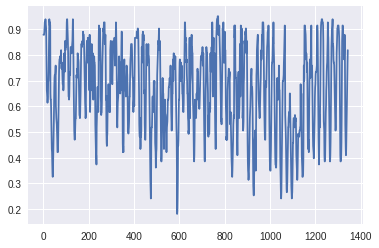

In [0]:
batch = 0  
signal = 5 
seq = x_batch[batch, :, signal]
plt.plot(seq)

Plot one of the output signals(here 1st signal - again Temperature)

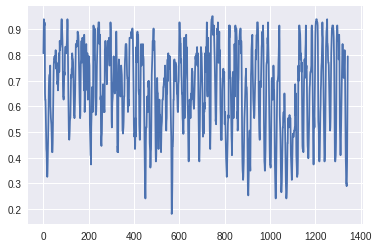

In [0]:
seq = y_batch[batch, :, 1]
plt.plot(seq)

# Validation Set

This is done to prevent overfitting. In case, if there is no improvement after an epoch, the model's weight wont be saved. 

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Create RNN

Initialise model with Keras API. Add a Gated Recurrent Unit(GRU) to the model. This will have 512 outputs for each timestep in the sequence. 

In [0]:
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

We only predict 2 featres, namely, Temperature and humidity. For that, we need to predict only 2 signals from 512 values. Hence, we use a fully connected Dense layer to map the 512 values to 2 values.

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

Use a linear activation function on the output to allow the output to take on arbitrary values.

In [0]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

Use MSE as loss function. During the initial few timesteps, the output predicted wont be accurate as it has seen only few timesteps. Hence we need not include the accuracy of loss function for few timesteps. Let us ignore the accuracy for first 50 timesteps.

In [0]:
warmup_steps = 50

In [0]:
def loss_mse_warmup(y_true, y_pred):
  
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean

Compile the model using RMSProp as the optimiser. RMSprop is an adaptive learning rate method which keeps a moving average of the squared gradient for each weight. 

In [0]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         811008    
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           1026      
Total params: 812,034
Trainable params: 812,034
Non-trainable params: 0
_________________________________________________________________


# Callback functions

In order to save checkpoints during training, we use TensorBoard to create callbacks. 

callback_checkpoint is used to write the checkpoints during training. 

In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping is used in case when the performance worsens on the training dataset. 

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

callback_tensorboard is used to write the log during training. 

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

Due to some reasons, in case if the validation loss does not improve from the previous epoch, we need to reduce the learning rate. This is done using callback_reduce_lr

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

# Train RNN

In [0]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
49/50 [============================>.] - ETA: 4s - loss: 0.0175
Epoch 00001: val_loss improved from inf to 0.01405, saving model to 23_checkpoint.keras
50/50 [==============================] - 214s 4s/step - loss: 0.0174 - val_loss: 0.0140
Epoch 2/20
49/50 [============================>.] - ETA: 4s - loss: 0.0127
Epoch 00002: val_loss improved from 0.01405 to 0.01106, saving model to 23_checkpoint.keras
50/50 [==============================] - 213s 4s/step - loss: 0.0126 - val_loss: 0.0111
Epoch 3/20
49/50 [============================>.] - ETA: 4s - loss: 0.0117
Epoch 00003: val_loss improved from 0.01106 to 0.01031, saving model to 23_checkpoint.keras
50/50 [==============================] - 213s 4s/step - loss: 0.0116 - val_loss: 0.0103
Epoch 4/20
49/50 [============================>.] - ETA: 4s - loss: 0.0112
Epoch 00004: val_loss did not improve from 0.01031

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
50/50 [========================

# Load Checkpoint

This is used in case loss performance does not improve from its previous epoch. 

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

# Evaluate Performance

Performance of the model is evaluated on the test set. 

In [0]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 8s 8s/step


In [0]:
print("loss (test-set):", result)

loss (test-set): 0.009188167750835419


# Plot Predictions

In [0]:
def plot_comparison(start_idx, length=100, train=True):
  
    if train:
        x = x_train_scaled
        y_true = y_train
    else:
        x = x_test_scaled
        y_true = y_test
    
    end_idx = start_idx + length
    
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_classes)):
        signal_pred = y_pred_rescaled[:, signal]
        
        signal_true = y_true[:, signal]

        plt.figure(figsize=(15,5))
        
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        plt.ylabel(target_classes[signal])
        plt.legend()
        plt.show()

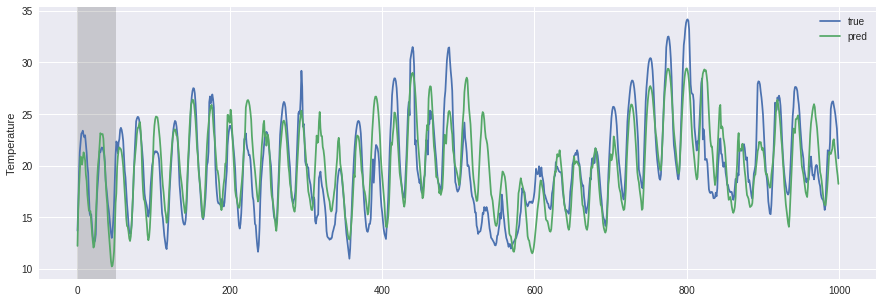

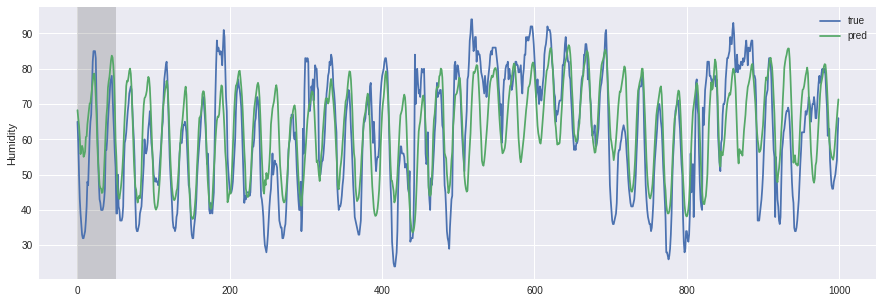

In [0]:
plot_comparison(start_idx=50000, length=1000, train=True)